# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year}.tsv``, ``positive_validation_{}_years_after_{}_target_{}.tsv``, ``negative_prediction_upto_{year}.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

In [2]:
target_year = 2010
mid_year = 2019
num_years_later = 1

## Input files
``embedding_SG_dim100_upto{year}.npy`` is the result of word2vec embedding of pubmed. ``words_SG_upto{}.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 195088 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2010.npy and ../data/embeddings_final/words_SG_upto2010.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-2.641621,3.124869,-4.353377,-2.018315,1.823348,-4.975201,-4.787686,2.649930,-2.948251,-0.916163,...,-1.869853,-3.522519,2.618166,-4.450459,-3.961528,-2.892118,-5.928490,0.367299,-4.532290,2.421597
patient,-3.817505,2.731132,-3.133406,-3.360924,3.251447,-3.779796,-4.411118,2.816041,-5.475833,-2.382731,...,-1.941187,-5.431289,2.350188,-5.862311,-3.625207,-4.146669,-4.293906,0.900865,-4.954704,3.698488
meshd009369,-2.000293,2.692290,-3.906482,-2.403826,2.087734,-4.683461,-4.715221,3.363425,-3.719787,-1.557153,...,-1.572250,-5.367291,2.859295,-5.173111,-5.736109,-3.077639,-3.752953,0.597677,-3.388928,4.321077
study,-3.286283,2.197396,-3.055143,-3.488384,1.583849,-3.476388,-4.572982,2.568147,-4.655032,-2.002333,...,-1.750167,-4.790527,2.999226,-5.209653,-4.173866,-6.466439,-4.163732,0.406401,-3.173547,2.894467
1,-1.973735,2.599354,-4.169664,-2.950947,1.642805,-4.464195,-4.122997,3.285105,-3.085233,-2.332377,...,-1.851673,-4.228116,2.728837,-6.189056,-3.837825,-5.297565,-4.471994,0.961740,-3.943491,3.863080
0,-2.586123,2.689704,-4.212170,-3.771425,1.231912,-4.831149,-4.203139,2.516318,-4.278717,-0.870984,...,-1.646774,-3.917393,3.147377,-6.403146,-3.208885,-4.337939,-5.274619,1.493022,-4.262381,3.811445
case,-2.901989,3.094942,-2.662760,-2.999618,3.339018,-4.174236,-3.733308,3.043080,-5.015265,-2.009101,...,-1.629706,-5.274364,2.490766,-6.020258,-4.223149,-5.065413,-4.717482,1.171679,-4.160813,3.578443
2,-1.995389,2.613357,-4.465601,-3.374403,1.476374,-3.963554,-4.275064,3.415569,-3.165894,-2.673264,...,-1.870650,-4.507325,2.781323,-6.268209,-3.587891,-5.258845,-4.164574,0.931996,-4.031983,3.908941
use,-2.350996,2.471157,-3.943660,-4.285838,1.903959,-3.824636,-5.363203,3.795658,-3.144410,-2.605247,...,-1.496192,-3.672382,3.161894,-3.771332,-5.287291,-5.904677,-6.007619,0.785128,-5.524373,3.306188
treatment,-4.137800,2.313303,-4.491300,-4.538378,2.906991,-3.536086,-5.214668,3.688766,-3.349134,-2.446090,...,-1.661259,-3.453831,2.958672,-6.402697,-2.986871,-6.025044,-3.379093,0.627732,-5.395659,5.521724


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  195088


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd015179,ncbigene1956
1,meshd009362,ncbigene1956
2,meshd016609,ncbigene1956
3,meshd008113,ncbigene1956
4,meshd002289,ncbigene1956


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

161 positive examples
195088 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 132 kinase-cancer difference vectors
[INFO]	Initial data: 161 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 0 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd015179,-1.758768,0.821506,-0.218957,-0.418908,1.173821,2.282200,-0.896008,0.869499,-0.596625,-1.125477,...,0.244606,-0.978184,-0.364866,-0.861954,2.721985,0.355013,-1.774969,0.447741,0.221942,0.967503
ncbigene1956-meshd009362,-0.488660,-0.127344,1.152679,-1.458963,0.629901,1.370382,-0.432642,-0.060593,-0.768857,-0.831967,...,-0.106943,-2.545844,1.020391,2.764358,0.198052,-1.228320,-2.482996,0.121853,-0.002106,-0.983001
ncbigene1956-meshd016609,1.205292,0.113798,-1.177771,-1.224409,-0.320766,0.655336,-1.157197,1.443528,-1.263317,-1.750137,...,0.342476,-3.346388,-0.123938,-0.298214,0.739539,-0.900963,-2.440659,1.079363,0.378580,-1.017632
ncbigene1956-meshd008113,0.243748,0.850496,-0.247731,-1.412440,-1.462184,3.085130,-1.012596,2.120200,-1.968772,-2.174910,...,0.080879,-2.727978,0.043658,-0.467317,0.111648,0.602614,-2.497726,0.504189,-1.959718,0.611904
ncbigene1956-meshd002289,-0.197365,0.567358,-0.211547,0.391760,0.885465,2.867372,0.110631,1.182542,1.366991,-1.176261,...,0.283839,-0.278417,0.089316,0.738022,1.080370,-0.954275,-1.885794,0.135279,-1.811702,-0.210935


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

132 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd001353,ncbigene51347
1,meshd054446,ncbigene9943
2,meshd005770,ncbigene1460
3,meshd001005,ncbigene494551
4,meshd012004,ncbigene558


In [12]:
print("%d negative examples" % len(negative_df))

1350 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 1139 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 40 gene ids
[INFO]	Could not identify 47 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene51347-meshd001353,0.634791,-0.161535,0.771940,0.967153,0.033578,1.162121,1.368057,-0.527410,1.108876,0.350680,...,0.431654,1.170699,-0.201616,1.438968,1.563396,1.144998,1.243870,0.417939,1.041905,-1.016735
ncbigene9943-meshd054446,-0.131816,0.240426,-0.435038,-0.147016,0.037750,-0.527301,-0.349059,0.082920,-0.490304,-0.000799,...,0.266909,-0.499853,0.230114,-0.827119,-0.514482,-0.827765,-0.622165,-0.008374,-0.501817,0.274886
ncbigene1460-meshd005770,-0.546945,0.908004,-1.691925,-1.951773,0.514862,-0.994207,-1.802731,2.067202,-1.858484,-1.132598,...,-0.514249,-1.661207,1.092049,-2.550779,-1.815577,-1.049185,-1.204009,0.346264,-1.396917,1.255117
ncbigene494551-meshd001005,1.341161,-1.231676,0.854529,2.003443,-0.694873,2.177730,1.463443,-1.506111,2.261719,0.600371,...,0.756121,2.521577,-1.683816,1.941912,1.905301,1.656121,2.435008,-0.888347,1.691471,-1.901341
ncbigene558-meshd012004,-0.257157,0.179581,0.623878,1.265182,0.662319,1.630721,0.375043,-1.390426,1.808904,0.333108,...,0.068284,2.950310,-0.962457,0.901533,1.095526,1.270001,1.310992,-0.291677,1.997519,-2.295386


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=132) and negative (n=1139) to the combined dataframe (1271)


In [16]:
X_train.values

array([[-1.7587682e+00,  8.2150578e-01, -2.1895671e-01, ...,
         4.4774115e-01,  2.2194195e-01,  9.6750259e-01],
       [-4.8866010e-01, -1.2734413e-01,  1.1526792e+00, ...,
         1.2185264e-01, -2.1064281e-03, -9.8300052e-01],
       [ 1.2052921e+00,  1.1379838e-01, -1.1777706e+00, ...,
         1.0793628e+00,  3.7857962e-01, -1.0176322e+00],
       ...,
       [ 5.7362437e-01, -6.5514970e-01,  7.8091526e-01, ...,
        -3.6973724e-01,  5.5240083e-01,  2.3941994e-02],
       [ 2.8310804e+00, -1.0791543e+00,  1.3244100e+00, ...,
        -1.4089571e+00,  1.0236242e+00,  1.1126995e-02],
       [ 2.1023273e-01, -1.1287615e+00,  6.2883067e-01, ...,
        -1.4348540e+00,  6.0686493e-01,  4.2965484e-01]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.60468894 0.05395933 0.03472241]


Text(0, 0.5, 'PC 2 (5.40%)')

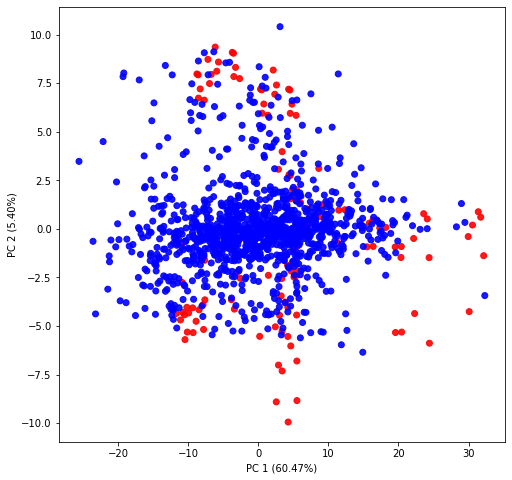

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1271 samples in 0.001s...
[t-SNE] Computed neighbors for 1271 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1271
[t-SNE] Computed conditional probabilities for sample 1271 / 1271
[t-SNE] Mean sigma: 1.184032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.553753
[t-SNE] KL divergence after 300 iterations: 0.696788
t-SNE done! Time elapsed: 2.6320700645446777 seconds


Text(0, 0.5, 'tsne-2d-two')

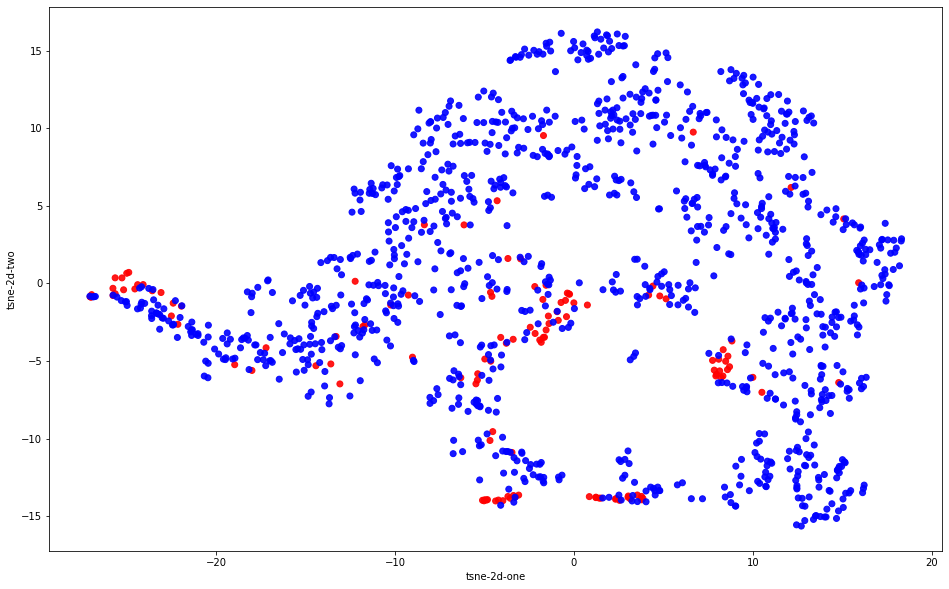

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (1271, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 132, number of negative examples: 1139, Y_train.shape: (1271,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_target_{}.tsv".format(num_years_later, mid_year,target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd012512,ncbigene1021
1,meshd002291,ncbigene780
2,meshd009423,ncbigene660
3,meshd002583,ncbigene25
4,meshd046152,ncbigene2321


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 1270 kinase-cancer difference vectors
[INFO]	Initial data: 1360 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 10 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene780-meshd002291,1.388020,-1.150149,0.185972,-0.247900,-1.248628,0.311284,-0.453292,-1.542218,1.145246,0.114743,...,-0.161523,0.947809,-0.422761,2.376299,1.312004,1.498799,0.248714,-0.328810,1.171005,-0.487922
ncbigene660-meshd009423,0.790722,-0.545801,0.659592,-1.065566,-1.141480,1.679262,-0.333260,0.552076,-0.262992,0.350337,...,0.149366,1.056125,-1.412055,0.981328,1.626519,1.029959,0.406803,-0.395323,-0.795840,-1.319790
ncbigene25-meshd002583,1.145791,1.345809,-1.329598,-0.830372,2.884999,0.962489,-1.098625,-1.363733,1.984213,0.165077,...,-0.095920,1.989887,-0.530370,-0.882482,1.950228,-0.479237,0.303671,-1.365832,-1.362251,-3.666002
ncbigene2321-meshd046152,0.937959,-0.526610,-0.443857,0.970272,-2.518729,0.836183,-0.578669,-0.639421,1.408011,0.217335,...,-0.047003,-0.532291,-0.283694,0.779056,0.308362,-0.642313,-1.670493,1.316202,0.123740,1.229018
ncbigene3716-meshd054438,-1.530566,1.221968,-2.863503,-2.558001,1.265183,-0.697025,-1.738167,2.450326,-2.059422,-0.681017,...,-1.430329,-1.683077,0.758807,-3.098248,-1.397335,-2.164879,-2.183648,-0.108625,-1.888686,0.900710


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_upto_{}.tsv".format(target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd008039,ncbigene1859
1,meshd006394,ncbigene1020
2,meshd018227,ncbigene8767
3,meshd023981,ncbigene1859
4,meshd058405,ncbigene3706


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 1150 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 36 gene ids
[INFO]	Could not identify 47 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1859-meshd008039,0.535040,-0.895264,-0.483237,-1.297033,-0.008537,0.495120,-0.429202,-0.332339,0.366438,-0.591436,...,0.482066,0.759580,0.092918,0.595655,-0.145391,-0.267175,0.260258,-1.371472,1.006593,0.431882
ncbigene1020-meshd006394,0.855250,-0.338887,-0.820471,-1.683267,-0.655787,1.349600,-0.691756,-0.674073,-1.372741,0.227001,...,0.220362,-0.140795,0.705625,0.107965,-0.073587,-0.328899,-0.848821,-0.467309,-1.152355,0.583802
ncbigene8767-meshd018227,1.332242,-1.730234,-0.113621,-1.034281,0.002727,1.206214,-0.622192,-0.507969,0.165140,1.018060,...,0.313415,-0.040057,-0.497603,-0.239033,-0.006150,-0.149474,0.699407,-0.980530,-0.082950,0.200639
ncbigene1859-meshd023981,2.225901,-1.134775,0.028069,-1.311161,-1.130909,0.293522,-0.087080,-0.099379,-0.296874,-0.380312,...,0.728853,0.120893,0.639847,0.406204,0.675138,-0.451730,0.204170,-0.872154,1.680992,0.286414
ncbigene3706-meshd058405,1.845238,-2.088803,2.472573,1.006933,-1.049871,3.678366,2.819821,-1.919859,1.175564,0.634574,...,0.253349,2.589711,-1.103578,4.136767,2.601037,3.208991,2.796930,-1.351703,2.342370,-2.775809


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-target-{}.pkl".format(num_years_later, mid_year,target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path ="positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}.pkl".format(target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)